# Password Strength Predictor

This notebook demonstrates a password strength predictor model using an XGBoost classifier. The model is trained on a dataset containing passwords labeled with their respective strength levels. Various features are created, such as password length, frequency of uppercase letters, lowercase letters, numbers, and special characters.

The model uses a <u>combination of TF-IDF vectorized features and custom-generated features</u> to predict the strength of a given password, achieving an accuracy of **99.67%**.

## Data Source
The dataset used for training the model is sourced from Kaggle:
[Password Strength Classifier Dataset](https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset)

# Production Model

Cross-validation Scores: [0.99688267 0.99695734 0.99638797 0.99694798 0.99687331]
Mean CV Score: 0.9968098526441391
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17833
           1       1.00      1.00      1.00     99525
           2       1.00      1.00      1.00     16570

    accuracy                           1.00    133928
   macro avg       0.99      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



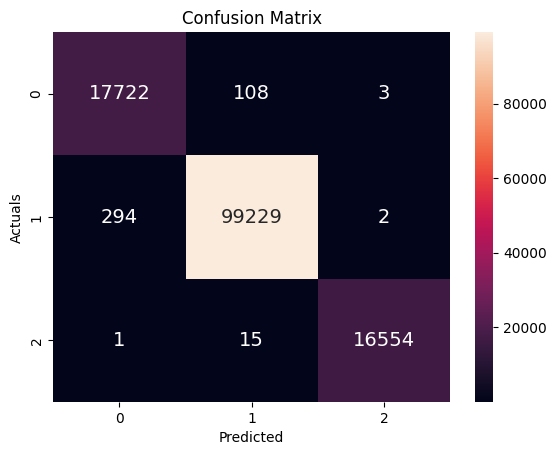

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

path = os.getcwd() + '/data.csv'
df_raw = pd.read_csv(path, on_bad_lines='skip')

class mrsimz_password_prod_model():
    def __init__(self, test_split : float = 0.2, randomizer : int = 42, xgb_param : dict = None, model_report : bool = True) -> None:
        self.test_split = test_split
        self.randomizer = randomizer
        self.model_report = model_report
        if xgb_param is None:
            self.xgb_param = {
                                'colsample_bytree': 1.0, 
                                'gamma': 0.1, 
                                'learning_rate': 0.2, 
                                'max_depth': 5, 
                                'n_estimators': 200, 
                                'reg_alpha': 0, 
                                'reg_lambda': 1.5, 
                                'subsample': 0.8,
                                'objective': 'binary:logistic'
                            }
        else:
            self.xgb_param = xgb_param
    
    def feature_creation(self, df : pd.DataFrame) -> pd.DataFrame:
        df_raw.dropna(inplace=True)
        df['password'] = df['password'].astype(str)
        df['length'] = df['password'].apply(len)
        df['caps_alpbts'] = df['password'].apply(lambda x : len(re.findall('[A-Z]', x)))/df['length']
        df['small_alpbts'] = df['password'].apply(lambda x : len(re.findall('[a-z]', x)))/df['length']
        df['num'] = df['password'].apply(lambda x : len(re.findall('[0-9]', x)))/df['length']
        df['comon_chars'] = df['password'].apply(lambda x : len(re.findall('[@_!#$%^&*()<>?/\\|{ }~:\\[\\]]', x)))/df['length']
        df['unique_chars'] = df['password'].apply(lambda x : len(re.findall('[^a-zA-Z0-9@_!#$%^&*()+-<>?/\|{ }~:\\[\\]]', x)))/df['length']
        return df
    
    def data_prep(self, data):
        if isinstance(data, str):
            processed_data = pd.DataFrame({'password':[data]})
        elif isinstance(data, (np.ndarray, list)):
            processed_data = pd.DataFrame({'password':data})
        else:
            raise ValueError("Input data must be a string, list, or numpy array")

        processed_data = self.feature_creation(processed_data)
        temp = self.tfidf.transform(processed_data["password"].values).toarray()

        return np.concatenate((temp, processed_data.iloc[:,2:]), axis=1)

    def fit(self, df_raw : pd.DataFrame):
        
        # Custom features genrated which will have frequency of character type
        df_new = self.feature_creation(df_raw.copy())

        x_temp = df_new["password"].values
        y = df_new["strength"].values

        # Creating vectorized characters as features
        self.tfidf = TfidfVectorizer(analyzer='char', lowercase=False, token_pattern=None)
        x_temp_2 = self.tfidf.fit_transform(x_temp).toarray()

        # Combining both the feature set
        x = np.concatenate((x_temp_2, df_new.iloc[:,3:]), axis=1)

        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=self.randomizer, test_size=self.test_split)

        self.model = xgb.XGBClassifier(**self.xgb_param)
        self.model.fit(x_train, y_train)

        if self.model_report:
    
            cv_scores = cross_val_score(self.model, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
            print("Cross-validation Scores:", cv_scores)
            print("Mean CV Score:", np.mean(cv_scores))

            print(classification_report(y_test, self.model.predict(x_test)))

            sns.heatmap(confusion_matrix(y_test, self.model.predict(x_test)), annot=True, annot_kws={'size':14}, fmt='d')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actuals')
            plt.show()

            self.feature_df = pd.DataFrame({'features':np.concatenate((self.tfidf.get_feature_names_out(), df_new.columns[3:])), 'feature_importance':self.model.feature_importances_}).sort_values(by='feature_importance', ascending=True)
            fig = px.bar(self.feature_df.tail(20), y='features', x='feature_importance', title='Feature Importance', height=800)
            fig.update_yaxes(title_text='Top 20 Features')
            fig.show()

    def predict(self, password):
        return self.model.predict(self.data_prep(password))

    def predict_proba(self, password):
        return self.model.predict_proba(self.data_prep(password))
    
prod_model = mrsimz_password_prod_model()
prod_model.fit(df_raw)

In [4]:
user = ["fow", 'My8%¨ˇ', "fow Mmmmm", 'nkvds3212nkVnks', 'AAA', 'AAAAAAAAAA', 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']
prediction = prod_model.predict(user)
print(f"Prediction for \n{user} \n{prediction}")

Prediction for 
['fow', 'My8%¨ˇ', 'fow Mmmmm', 'nkvds3212nkVnks', 'AAA', 'AAAAAAAAAA', 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'] 
[0 2 1 2 0 0 0]


## Production Candidates

### Initilizing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

path = os.getcwd() + '/data.csv'
df_raw = pd.read_csv(path, on_bad_lines='skip')

### Model 1 : Custom Features Only

In [ ]:
class mrsimz_password_model_1():

    def __init__(self, test_split : float = 0.2, randomizer : int = 42, xgb_param : dict = None, model_report : bool = True) -> None:
        self.test_split = test_split
        self.randomizer = randomizer
        self.model_report = model_report
        if xgb_param is None:
            self.xgb_param = {
                                'colsample_bytree': 1.0, 
                                'gamma': 0.1, 
                                'learning_rate': 0.2, 
                                'max_depth': 5, 
                                'n_estimators': 200, 
                                'reg_alpha': 0, 
                                'reg_lambda': 1.5, 
                                'subsample': 0.8,
                                'objective': 'binary:logistic'
                            }
        else:
            self.xgb_param = xgb_param

    def feature_creation(self, df : pd.DataFrame) -> pd.DataFrame:
        df_raw.dropna(inplace=True)
        df['password'] = df['password'].astype(str)
        df['length'] = df['password'].apply(len)
        df['caps_alpbts'] = df['password'].apply(lambda x : len(re.findall('[A-Z]', x)))/df['length']
        df['small_alpbts'] = df['password'].apply(lambda x : len(re.findall('[a-z]', x)))/df['length']
        df['num'] = df['password'].apply(lambda x : len(re.findall('[0-9]', x)))/df['length']
        df['comon_chars'] = df['password'].apply(lambda x : len(re.findall('[@_!#$%^&*()<>?/\\|{ }~:\\[\\]]', x)))/df['length']
        df['unique_chars'] = df['password'].apply(lambda x : len(re.findall('[^a-zA-Z0-9@_!#$%^&*()+-<>?/\|{ }~:\\[\\]]', x)))/df['length']
        return df

    def data_prep(self, data):
        if isinstance(data, str):
            processed_data = pd.DataFrame({'password':[data]})
        elif isinstance(data, (np.ndarray, list)):
            processed_data = pd.DataFrame({'password':data})
        else:
            raise ValueError("Input data must be a string, list, or numpy array")
    
        processed_data = self.feature_creation(processed_data)
        return processed_data.drop(columns=['password', 'length'])

    def fit(self, df_raw):
        df_processed = self.feature_creation(df_raw.copy())

        x = df_processed.drop(columns=['password', 'length', 'strength'])
        y = df_processed['strength'].values

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.test_split, random_state=self.randomizer)

        self.model = xgb.XGBClassifier(**self.xgb_param)
        self.model.fit(x_train, y_train)

        # Model Report
        if self.model_report:
            y_pred = self.model.predict(x_test)

            print('Accuracy Score :', accuracy_score(y_test, y_pred))

            # Heat Map
            plt.figure(figsize=(8, 6))
            
            sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True, annot_kws={'size':14})
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Values')
            plt.ylabel('Actuals')

            # Feature Importance
            feature_imp_df = pd.DataFrame({'features' : self.model.get_booster().feature_names, 'feature_importance' : self.model.feature_importances_}).sort_values(by=['feature_importance'], ascending=[False])
            fig = px.bar(feature_imp_df, x='features', y='feature_importance')
            fig.show()

            print(classification_report(y_test, y_pred))

    def predict(self, password):
        return self.model.predict(self.data_prep(password))
    
    def predict_proba(self, password):
        return self.model.predict_proba(self.data_prep(password))


my_model_1 = mrsimz_password_model_1()
my_model_1.fit(df_raw)

### Model 2 : TFIDF Only

In [ ]:
class mrsimz_password_model_2():
    def __init__(self, test_split : float = 0.2, randomizer : int = 42, xgb_param : dict = None, model_report : bool = True) -> None:
        self.test_split = test_split
        self.randomizer = randomizer
        self.model_report = model_report
        if xgb_param is None:
            self.xgb_param = {
                                'colsample_bytree': 1.0, 
                                'gamma': 0.1, 
                                'learning_rate': 0.2, 
                                'max_depth': 5, 
                                'n_estimators': 200, 
                                'reg_alpha': 0, 
                                'reg_lambda': 1.5, 
                                'subsample': 0.8,
                                'objective': 'binary:logistic'
                            }
        else:
            self.xgb_param = xgb_param

    def fit(self, df_raw : pd.DataFrame):
        df_raw.dropna(inplace=True)

        x = df_raw["password"].values
        y = df_raw["strength"].values

        self.tfidf = TfidfVectorizer(analyzer='char', lowercase=False, token_pattern=None)
        x = self.tfidf.fit_transform(x)

        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=self.randomizer, test_size=self.test_split)

        self.model = xgb.XGBClassifier(**self.xgb_param)
        self.model.fit(x_train, y_train)

        if self.model_report:
            y_pred = self.model.predict(x_test)
            print('Model Accuracy :', self.model.score(x_test, y_test))
            print(classification_report(y_test, y_pred))

            sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={'size':14}, fmt='d')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actuals')
            plt.show()

            self.feature_df = pd.DataFrame({'features':self.tfidf.get_feature_names_out(), 'feature_importance':self.model.feature_importances_}).sort_values(by='feature_importance', ascending=True)
            fig = px.bar(self.feature_df.tail(20), y='features', x='feature_importance', title='Feature Importance', height=800)
            fig.update_yaxes(title_text='Top 20 Features')
            fig.show()

    def predict(self, password):
        return self.model.predict(self.tfidf.transform(password))

    def predict_proba(self, password):
        return self.model.predict_proba(self.tfidf.transform(password))
    
my_model_2 = mrsimz_password_model_2()
my_model_2.fit(df_raw)

### Model 3 : Combination

In [ ]:
class mrsimz_password_model_3():
    def __init__(self, test_split : float = 0.2, randomizer : int = 42, xgb_param : dict = None, model_report : bool = True) -> None:
        self.test_split = test_split
        self.randomizer = randomizer
        self.model_report = model_report
        if xgb_param is None:
            self.xgb_param = {
                                'colsample_bytree': 1.0, 
                                'gamma': 0.1, 
                                'learning_rate': 0.2, 
                                'max_depth': 5, 
                                'n_estimators': 200, 
                                'reg_alpha': 0, 
                                'reg_lambda': 1.5, 
                                'subsample': 0.8,
                                'objective': 'binary:logistic'
                            }
        else:
            self.xgb_param = xgb_param
    
    def feature_creation(self, df : pd.DataFrame) -> pd.DataFrame:
        df_raw.dropna(inplace=True)
        df['password'] = df['password'].astype(str)
        df['length'] = df['password'].apply(len)
        df['caps_alpbts'] = df['password'].apply(lambda x : len(re.findall('[A-Z]', x)))/df['length']
        df['small_alpbts'] = df['password'].apply(lambda x : len(re.findall('[a-z]', x)))/df['length']
        df['num'] = df['password'].apply(lambda x : len(re.findall('[0-9]', x)))/df['length']
        df['comon_chars'] = df['password'].apply(lambda x : len(re.findall('[@_!#$%^&*()<>?/\\|{ }~:\\[\\]]', x)))/df['length']
        df['unique_chars'] = df['password'].apply(lambda x : len(re.findall('[^a-zA-Z0-9@_!#$%^&*()+-<>?/\|{ }~:\\[\\]]', x)))/df['length']
        return df
    
    def data_prep(self, data):
        if isinstance(data, str):
            processed_data = pd.DataFrame({'password':[data]})
        elif isinstance(data, (np.ndarray, list)):
            processed_data = pd.DataFrame({'password':data})
        else:
            raise ValueError("Input data must be a string, list, or numpy array")

        processed_data = self.feature_creation(processed_data)
        temp = self.tfidf.transform(processed_data["password"].values).toarray()

        return np.concatenate((temp, processed_data.iloc[:,2:]), axis=1)

    def fit(self, df_raw : pd.DataFrame):

        df_new = self.feature_creation(df_raw.copy())

        x_temp = df_new["password"].values
        y = df_new["strength"].values

        self.tfidf = TfidfVectorizer(analyzer='char', lowercase=False, token_pattern=None)
        x_temp_2 = self.tfidf.fit_transform(x_temp).toarray()

        x = np.concatenate((x_temp_2, df_new.iloc[:,3:]), axis=1)

        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=self.randomizer, test_size=self.test_split)

        self.model = xgb.XGBClassifier(**self.xgb_param)
        self.model.fit(x_train, y_train)

        if self.model_report:
    
            # cv_scores = cross_val_score(self.model, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
            # print("Cross-validation Scores:", cv_scores)
            # print("Mean CV Score:", np.mean(cv_scores))

            print(classification_report(y_test, self.model.predict(x_test)))

            sns.heatmap(confusion_matrix(y_test, self.model.predict(x_test)), annot=True, annot_kws={'size':14}, fmt='d')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actuals')
            plt.show()

            self.feature_df = pd.DataFrame({'features':np.concatenate((self.tfidf.get_feature_names_out(), df_new.columns[3:])), 'feature_importance':self.model.feature_importances_}).sort_values(by='feature_importance', ascending=True)
            fig = px.bar(self.feature_df.tail(20), y='features', x='feature_importance', title='Feature Importance', height=800)
            fig.update_yaxes(title_text='Top 20 Features')
            fig.show()

    def predict(self, password):
        return self.model.predict(self.data_prep(password))

    def predict_proba(self, password):
        return self.model.predict_proba(self.data_prep(password))
    
my_model_3 = mrsimz_password_model_3()
my_model_3.fit(df_raw)

In [ ]:
user = ["fow", 'My8%¨ˇ', "fow Mmmmm", 'nkvds3212nkVnks', 'ds9n3VnkJM', 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA']
prediction_1 = my_model_1.predict(user)
prediction_2 = my_model_2.predict(user)
prediction_3 = my_model_3.predict(user)
print(f"Prediction for '{user}' from approach 1: {prediction_1}")
print(f"Prediction for '{user}' from approach 2: {prediction_2}")
print(f"Prediction for '{user}' from approach 3: {prediction_3}")

## Data and Model Exploration

Note : Just to be used to see how I worked and tried different approaches before finalizing the prod approach 

### Initilizing

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [ ]:
path = os.getcwd() + '/data.csv'

df_raw = pd.read_csv(path, on_bad_lines='skip')
df_raw.shape

### Approach 1 : Feature based

#### EDA Phase 1

In [ ]:
df_raw.head()

In [ ]:
df_raw.duplicated().sum()

In [ ]:
df_raw.isnull().sum()

In [ ]:
df_raw.dropna(inplace=True)

In [ ]:
df_raw['strength'].value_counts()

#### Feature Creation

##### Number of Features to be created
1. Length - ✅
2. freq Alphabets (Caps  & Small) - ✅
3. freq Numericals - ✅
4. freq Special Characters - ✅
5. Commonly used characters/ unique char - ✅

Below features will be created if model accuracy is low

6. Contains sequence ? 
7. Contains repetition of characters ? more than 3 letters 
8. Contains a repeated phrase ?

In [ ]:
df = df_raw.copy()
df['length'] = df['password'].apply(len)
df['caps_alpbts'] = df['password'].apply(lambda x : len(re.findall('[A-Z]', x)))/df['length']
df['small_alpbts'] = df['password'].apply(lambda x : len(re.findall('[a-z]', x)))/df['length']
df['num'] = df['password'].apply(lambda x : len(re.findall('[0-9]', x)))/df['length']
df['comon_chars'] = df['password'].apply(lambda x : len(re.findall('[@_!#$%^&*()<>?/\\|{ }~:\\[\\]]', x)))/df['length']
df['unique_chars'] = df['password'].apply(lambda x : len(re.findall('[^a-zA-Z0-9@_!#$%^&*()+-<>?/\|{ }~:\\[\\]]', x)))/df['length']
# df['repetition'] = 
df.head()

In [ ]:
df[df['unique_chars'] != 0]

#### EDA 2

In [ ]:
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file(output_file = 'output.html')

In [ ]:
new = df.groupby('strength').agg(
    count=('length', 'size'),
    min_length=('length', 'min'),
    max_length=('length', 'max')
).reset_index()

new

In [ ]:
fig = px.box(df, x='strength', y='length', color='strength')
fig.show()

##### Count Plots

In [ ]:
fig = px.histogram(df.sort_values(by=['strength']), x='length', color='strength', barmode='stack',
                   title='Password Length Distribution by Strength',
                   labels={'length': 'Password Length', 'count': 'Count'})

# Show the plot
fig.show()

In [ ]:
df_grouped = df.groupby(['strength', 'length']).size().reset_index(name='count')

px.line(df_grouped, x='length', y='count', color='strength')

#### Data prepration for modelling

In [ ]:
# Train Test Data Split
x = df.drop(columns=['password', 'strength', 'length'])
y = df['strength'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Model

In [ ]:
def model_metrics(model, actuals, prediction):    
    sns.heatmap(confusion_matrix(actuals, prediction), annot=True, fmt='d', annot_kws={"size": 14})
    plt.xlabel('Predicted Categories')
    plt.ylabel('Actual Categories')
    plt.title('Confusion Matrix')

    df_feature_imp = pd.DataFrame({'feature':model.get_booster().feature_names, 'feature_importance':model.feature_importances_})
    fig = px.bar(df_feature_imp, x='feature', y='feature_importance')
    fig.show()

    print(classification_report(actuals, prediction))

##### Base model

In [ ]:
base_model = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
base_model.fit(x_train, y_train)
base_pred = base_model.predict(x_test)

accuracy_score(y_test, base_pred)

In [ ]:
model_metrics(base_model, y_test, base_pred)

##### Hyperparameter Tuning : Grid Search

In [ ]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2],
#     'objective': 'binary:logistic'
# }

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [1, 1.5, 2.0],
#     'objective': 'binary:logistic'
# }

# model_grid = xgb.XGBClassifier()
# grid_search = GridSearchCV(estimator=model_grid, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
# grid_search.fit(x_train, y_train)
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

Run time - 298m 21.6s

Avg fit - 2s

Best Parameters:  {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
Best Score:  0.9498255580446869

In [ ]:
new_params = {
    'colsample_bytree': 1.0, 
    'gamma': 0.1, 
    'learning_rate': 0.2, 
    'max_depth': 5, 
    'n_estimators': 200, 
    'reg_alpha': 0, 
    'reg_lambda': 1.5, 
    'subsample': 0.8,
    'objective': 'binary:logistic'
}

new_model = xgb.XGBClassifier(**new_params)
new_model.fit(x_train, y_train)
new_pred = new_model.predict(x_test)

accuracy_score(y_test, new_pred)

In [ ]:
model_metrics(new_model, y_test, new_pred)

In [ ]:
xgb.to_graphviz(new_model, num_trees=0, format='dot').render("xgboost_tree")

#### Further Analysis on 0 and 1 predictions

In [ ]:
df_result = pd.concat([x_test.reset_index(drop=True), pd.DataFrame(data=y_test, columns=['actual']), pd.DataFrame(data=new_pred, columns=['predicted'])], axis=1)
df_result.index = x_test.index
df_result.shape

In [ ]:
df_result.head()

In [ ]:
filtered_df = df_result[(df_result['actual'] != df_result['predicted']) & (df_result['actual'].isin([0,1]) | df_result['predicted'].isin([0,1]))]
filtered_df.head()

In [ ]:
df2 = pd.concat([df[['password', 'strength', 'length']], filtered_df], axis=1).dropna(subset=['actual'])
display(df2.head())
df2.shape

### Approach 2 : NLP - Tfidf Vectorization

#### Explore

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def feature_creation(df : pd.DataFrame) -> pd.DataFrame:
    df_raw.dropna(inplace=True)
    df['password'] = df['password'].astype(str)
    df['length'] = df['password'].apply(len)
    df['caps_alpbts'] = df['password'].apply(lambda x : len(re.findall('[A-Z]', x)))/df['length']
    df['small_alpbts'] = df['password'].apply(lambda x : len(re.findall('[a-z]', x)))/df['length']
    df['num'] = df['password'].apply(lambda x : len(re.findall('[0-9]', x)))/df['length']
    df['comon_chars'] = df['password'].apply(lambda x : len(re.findall('[@_!#$%^&*()<>?/\\|{ }~:\\[\\]]', x)))/df['length']
    df['unique_chars'] = df['password'].apply(lambda x : len(re.findall('[^a-zA-Z0-9@_!#$%^&*()+-<>?/\|{ }~:\\[\\]]', x)))/df['length']
    return df

df = feature_creation(df_raw)

x_temp = np.array(df["password"])
y = np.array(df["strength"])

In [ ]:
tfidf = TfidfVectorizer(analyzer="char", lowercase=False, token_pattern=None)
x_temp = tfidf.fit_transform(x_temp).toarray()

In [ ]:
print('Shape x_temp :', x_temp.shape)
print('Shape df :', df.iloc[:,3:].shape)

In [ ]:
x = np.concatenate((x_temp, df.iloc[:,3:].values), axis=1)
x.shape

In [ ]:
np.concatenate((tfidf.get_feature_names_out(), df.columns[3:]))

In [ ]:
list(df.columns[3:])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(x_train, y_train)
print("Score of the model is", rf_model.score(x_test, y_test), ".")

In [ ]:
new_params = {
    'colsample_bytree': 1.0, 
    'gamma': 0.1, 
    'learning_rate': 0.2, 
    'max_depth': 5, 
    'n_estimators': 200, 
    'reg_alpha': 0.6, 
    'reg_lambda': 1.5, 
    'subsample': 0.8
}

xgb_model = xgb.XGBClassifier(**new_params)
xgb_model.fit(x_train, y_train)
new_pred_data = xgb_model.predict(x_test)

xgb_model.score(x_test, y_test)

In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
logistic_pred = logistic_model.predict(x_test)

logistic_model.score(x_test, y_test)

In [ ]:
user = ["ckep4 2DS"]
data = tfidf.transform(user)
output0 = logistic_model.predict(data)
output1 = rf_model.predict(data)
output2 = xgb_model.predict(data)
print("Output 0 - Logistic Regression :", output0)
print("Output 1 - RandomForest :", output1)
print("Output 2 - XGBoost :", output2)